In [1]:
import sys  
sys.path.insert(0, '/Users/johanneswidera/Uni/bachelorarbeit/Code/models/')

In [2]:
from sklearn.model_selection import train_test_split
import numpy as np
import shap
import pandas as pd
import numpy as np
from sklearn import linear_model
from bs4 import BeautifulSoup
import contractions
import re
import string
from helper import load_csv
from model_helper.tf_idf import build_tf_idf
from model_helper.PipelineWrapper import PipelineWrapper
from custom_shap_explainer.custom_global import custom_global_explanation
from custom_shap_explainer.signal_words import highlight_signal_words
np.random.seed(1337)
shap.initjs()

/Users/johanneswidera/Uni/bachelorarbeit/Code/models/HUGGING_ENV/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/johanneswidera/Uni/bachelorarbeit/Code/models/HUGGING_ENV/lib/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-ba

                                    topic the concept of the topic  \
0  We should limit executive compensation   executive compensation   
1  We should limit executive compensation   executive compensation   
2  We should limit executive compensation   executive compensation   
3  We should limit executive compensation   executive compensation   
4  We should limit executive compensation   executive compensation   

                                           candidate  \
0  A say on pay - a non-binding vote of the gener...   
1  A February 2009 report, published by the Insti...   
2  The Financial Crisis has had a relatively smal...   
3  1990-1992 Lineberger Cancer Center, SPA person...   
4  Countering the public uproar over excessive ex...   

                                    candidate masked  label  \
0  A say on pay - a non-binding vote of the gener...      0   
1  A February 2009 report, published by the Insti...      1   
2  The Financial Crisis has had a relatively smal... 

# 1. Get Training Data 

In [3]:
def preprocessor(text):
  text = text.lower()
  text = contractions.fix(text)
  text = text.translate(str.maketrans(string.punctuation, " " * len(string.punctuation)))
  text = re.sub(' +', ' ', text)
  return text 

def load_data(source):
  data = pd.read_csv(source)
  # select only 2 columns
  data = data[['candidate', 'label']]
  # rename columns
  data.columns = ['text', 'label']
  data['text'] = data['text'].apply(preprocessor)
  return data['text'].tolist(), data['label'].tolist()

In [4]:
corpus_train, y_train = load_data('../data/train.csv')
corpus_test, y_test = load_data('../data/test.csv')

# 2. Build Vectorizer

In [5]:
vectorizer_tf_idf = build_tf_idf()
vectorizer_tf_idf.fit(corpus_train)

TfidfVectorizer(max_df=0.99, min_df=0.001)

# 3. Build Models

# 3.1 Build Logistic Regression Model

In [6]:
model = linear_model.LogisticRegression(penalty="l2")
model_logregression_new = PipelineWrapper(model, vectorizer_tf_idf, corpus_test, corpus_train, y_test, y_train)

In [7]:
model_logregression_new.fit()

In [8]:
model_logregression_new.report()

,0,1,accuracy,macro avg,weighted avg
precision,0.650876,0.819209,0.668219,0.735043,0.717798
recall,0.969082,0.212299,0.668219,0.590690,0.668219
f1-score,0.778727,0.337209,0.668219,0.557968,0.603199
support,1035.000000,683.000000,0.668219,1718.000000,1718.000000


# 3.2 Build Decision Tree Classifier

In [9]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(min_samples_leaf=20)
model_dtc = PipelineWrapper(model, vectorizer_tf_idf, corpus_test, corpus_train, y_test, y_train)

In [10]:
model_dtc.fit()

In [11]:
model_dtc.report()

,0,1,accuracy,macro avg,weighted avg
precision,0.650432,0.534831,0.620489,0.592632,0.604474
recall,0.800000,0.348463,0.620489,0.574231,0.620489
f1-score,0.717504,0.421986,0.620489,0.569745,0.600019
support,1035.000000,683.000000,0.620489,1718.000000,1718.000000


In [12]:
print(model_dtc.predict_proba([corpus_test[0]]))

[[0.96969697 0.03030303]]


# 4 Analyze With SHAP

We know that the Logistic Regression Performs better than the Decision Tree Classifier.
To further investigate why thats the case we need to look into the models.

In the following i will do 3 things.

Per Model:
1. Most Positive/Negative Words
2. Investigate the Most Wrong Positive and Negative prediction

Model Comparision:
1. Investigate biggest Prediction gap accross the models

In [13]:
def make_predictions(X_batch_text):
    X_batch = vectorizer_tf_idf.transform(X_batch_text)
    preds = model_logregression_new.predict_proba(X_batch)
    return preds


In [14]:
masker = shap.maskers.Text(tokenizer=r"\W+") # this will create a basic whitespace tokenizer
# explainer_logreg = shap.Explainer(model_logregression_new.predict_proba , masker)
explainer_logreg = shap.Explainer(model_logregression_new.predict_proba, masker)


In [15]:
shap_values_logreg = explainer_logreg(corpus_test[:200])

Partition explainer: 201it [00:13,  4.10it/s]                         


In [16]:
print(shap_values_logreg)

.values =
array([array([[-0.00142581,  0.00142581],
              [-0.00142581,  0.00142581],
              [-0.00051854,  0.00051854],
              [-0.00051854,  0.00051854],
              [-0.04278237,  0.04278237],
              [-0.00297529,  0.00297529],
              [ 0.04723   , -0.04723   ],
              [-0.0107262 ,  0.0107262 ],
              [-0.00193186,  0.00193186],
              [-0.0038649 ,  0.0038649 ],
              [-0.0312592 ,  0.0312592 ],
              [-0.03105613,  0.03105613],
              [ 0.00029097, -0.00029097],
              [ 0.01236421, -0.01236421],
              [ 0.00769786, -0.00769786],
              [ 0.02465057, -0.02465057],
              [ 0.00183908, -0.00183908],
              [ 0.01232915, -0.01232915],
              [-0.0080339 ,  0.0080339 ],
              [-0.00184671,  0.00184671],
              [ 0.01719223, -0.01719223],
              [-0.00288562,  0.00288562],
              [-0.01132807,  0.01132807],
              [-0.001308

### 4.1 Investigate the biggest misclassification


In [17]:
y_prob_test = model_logregression_new.predict_proba(corpus_test) # with probabilites
y_predict_test = model_logregression_new.predict(corpus_test) # with labels 1 and 2

In [18]:
y_prob_test_np = np.array(y_prob_test)
y_predict_test_np = np.array(y_predict_test)
y_test_np = np.array(y_test)

In [19]:
wrong_positive_indexes = np.where((y_test_np == 1) & (y_predict_test_np != y_test_np))[0]
print("Wrong Positive Indexes: ",wrong_positive_indexes.size)

wrong_negative_indexes = np.where((y_test_np == 0) & (y_predict_test_np != y_test_np))[0]
print("Wrong Negative Indexes: ",wrong_negative_indexes.size)

most_wrong_positive_index = wrong_positive_indexes[np.argmax(y_prob_test_np[wrong_positive_indexes,1])]
most_wrong_negative_index = wrong_negative_indexes[np.argmax(y_prob_test_np[wrong_negative_indexes,0])]

Wrong Positive Indexes:  538
Wrong Negative Indexes:  32


#### 4.1.2 Most Wrong Positive Classification

Most wrong review 

In [20]:
print(corpus_test[most_wrong_positive_index])
print("Real Label: ", y_test[most_wrong_positive_index])
print("Predicted Label: ", y_predict_test[most_wrong_positive_index])
print("Predicted Probability Label: ", y_prob_test[most_wrong_positive_index])

according to the american cancer society available scientific evidence does not support claims that naturopathic medicine can cure cancer or any other disease since virtually no studies on naturopathy as a whole have been published ref 
Real Label:  1
Predicted Label:  0
Predicted Probability Label:  [0.50004273 0.49995727]


so its 0.5 behind the real label.
But Why lets investigate

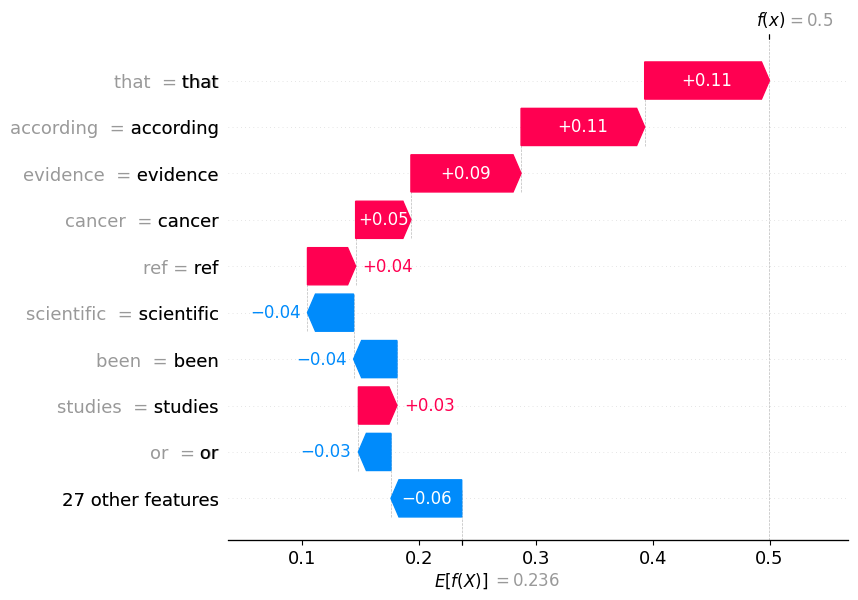

In [21]:
shap.plots.text(shap_values_logreg[most_wrong_positive_index])
shap.plots.waterfall(shap_values_logreg[most_wrong_positive_index, :, 1])

# interpretation:

Mit tf idf sind wir nicht in der lage den sinn in diesem text festzustellen

#### 4.1.2 Most Wrong Negative Classification

Most wrong review 

In [22]:
print(corpus_test[most_wrong_negative_index])
print("Real Label: ", y_test[most_wrong_negative_index])
print("Predicted Label: ", y_predict_test[most_wrong_negative_index])
print("Predicted Probability Label: ", y_prob_test[most_wrong_negative_index])

a lack of locations with constant wind environmental restrictions and emphasis by power utilities on fossil and nuclear power hinders the employment of more wind power in japan ref 
Real Label:  0
Predicted Label:  1
Predicted Probability Label:  [0.49975033 0.50024967]


In [23]:
shap.plots.text(shap_values_logreg[most_wrong_negative_index])
print(len(shap_values_logreg[most_wrong_negative_index]))
shap.plots.waterfall(shap_values_logreg[most_wrong_negative_index, :, 1])

IndexError: index 710 is out of bounds for axis 0 with size 200

# Interpretation:

The 10 was learned as something positive but the whole sentence is 2/10
so it should be positive.
This can give us a hint for better Tokenization.


# 4.1.3 Highlight Signal Words

To better Visualize the most important words in a classification we can highlight the only the top 5 Words with the highest impact on the result and top 5 Words with the lowest impact on the result
As you can see in the last example the text was to long to see anything.
So i do it again and only highlight the top 10 words.



In [ ]:
highlight_signal_words(shap_values_logreg[0, :, 1],round_shap_values=3,top_words=10)

print("IN COMPARISION THIS WOULD BE THE OUTPUT FROM SHAP")
shap.plots.text(shap_values_logreg[0, :, 1])


# 4.2 Global Interpretation Most Positive and negative Words

To understand how the model works

In [ ]:
custom_global_explanation(shap_values_logreg[:,:,1])

# 5. Analyze with SHAP: DTC

In [ ]:
masker = shap.maskers.Text(tokenizer=r"\W+") # this will create a basic whitespace tokenizer
# explainer_logreg = shap.Explainer(model_logregression_new.predict_proba , masker)
explainer_dtc = shap.Explainer(model_dtc.predict_proba, masker)

In [ ]:
shap_values_dtc = explainer_dtc(corpus_test[:200])

# 5.1 Local Effects

In [ ]:
shap.plots.text(shap_values_dtc[0, :, 1])

model_dtc.predict_proba([corpus_test[0]])

In [ ]:
shap.plots.text(shap_values_dtc[3, :, 1])

# 5.1.3 Custom Function to Highlight Signal Words 

In [ ]:
highlight_signal_words(shap_values_dtc[3, :, 1],round_shap_values=2,top_words=5)



#### interpretation:

you can directly see the Shap values Words with a Positive impact in the 1 percentile are very low and many words. you can directly see that the negative words only 4 lead the sentiment so mess even worse and crap this is great

# 5.2 Global Effects

In [ ]:
custom_global_explanation(shap_values_dtc[:,:,1])